In [1]:
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d
from scipy.spatial import Delaunay, delaunay_plot_2d
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
from skimage.draw import polygon
import matplotlib.pyplot as plt
import imageio
import cv2
import math
import json

## Part 1: Defining Correspondences

In [25]:
kobe, jay_z = cv2.imread("../media/kobe.jpg"), cv2.imread("../media/jay_z.jpg")
kobe, jay_z = cv2.cvtColor(kobe, cv2.COLOR_BGR2RGB), cv2.cvtColor(jay_z, cv2.COLOR_BGR2RGB)

In [26]:
praneet, shawty = cv2.imread("../media/praneet.png"), cv2.imread("../media/shawty.png")
praneet, shawty = cv2.cvtColor(praneet, cv2.COLOR_BGR2RGB), cv2.cvtColor(shawty, cv2.COLOR_BGR2RGB)

In [18]:
def get_mean_points_info(correspondenceFile):
    points = json.load(open(correspondenceFile,))
    img1_pts, img2_pts = np.array(points["im1Points"]), np.array(points["im2Points"]) # make sure not to mix them

    mean_points = (img1_pts + img2_pts) / 2
    return {
        "img1_pts": img1_pts,
        "img2_pts": img2_pts,
        "img1_img2_mean_pts": mean_points,
        "mean_points_tri": Delaunay(mean_points) # creating a list of mean points, connecting them all into triangles, and then returning the triangulation set for this list
    }

# kobe_jayz_mean_points_tri = get_mean_points_info('../media/jay_z_kobe.json')

In [29]:
rizz_mean_points_tri = get_mean_points_info('../media/praneet_shawty.json')

In [30]:
def show_img_with_same_triangulation(img, points, indices):
    fig, ax = plt.subplots()

    ax.imshow(img)
    ax.triplot(points[:, 0], points[:, 1], indices.simplices, color='r') # both images draw the same triangulation map, with different indices in this case
    ax.plot(points[:, 0], points[:, 1], 'bo')

    plt.axis('off')
    plt.show()

# show_img_with_same_triangulation(jay_z, kobe_jayz_mean_points_tri["img1_pts"], kobe_jayz_mean_points_tri["mean_points_tri"])
# show_img_with_same_triangulation(kobe, kobe_jayz_mean_points_tri["img2_pts"], kobe_jayz_mean_points_tri["mean_points_tri"])

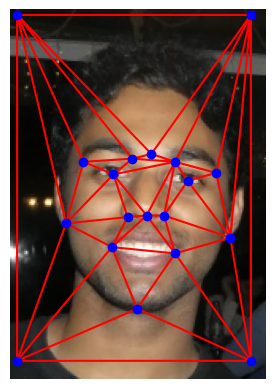

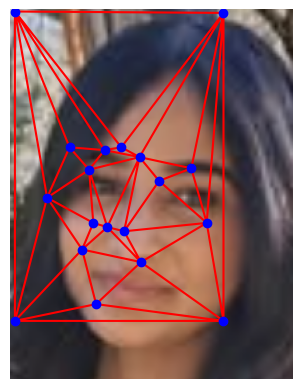

In [31]:
show_img_with_same_triangulation(praneet, rizz_mean_points_tri["img1_pts"], rizz_mean_points_tri["mean_points_tri"])
show_img_with_same_triangulation(shawty, rizz_mean_points_tri["img2_pts"], rizz_mean_points_tri["mean_points_tri"])

## Part 2: Computing the "Mid-way Face"

In [7]:
def show_img_with_avg_triangulation(img, mean_info):
    mean_points_tri, mean_points = mean_info["mean_points_tri"], mean_info["img1_img2_mean_pts"]
    
    fig, ax = plt.subplots()

    ax.imshow(img)
    ax.triplot(mean_points[:, 0], mean_points[:, 1], mean_points_tri.simplices, color='r')
    ax.plot(mean_points[:, 0], mean_points[:, 1], 'bo')

    plt.show()

# show_img_with_avg_triangulation(jay_z, kobe_jayz_mean_points_tri)
# show_img_with_avg_triangulation(kobe, kobe_jayz_mean_points_tri)

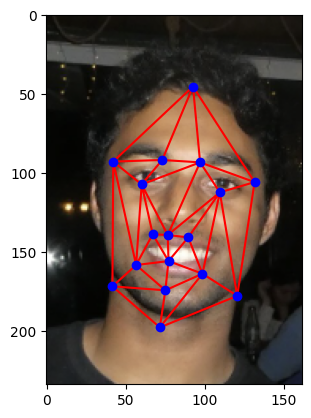

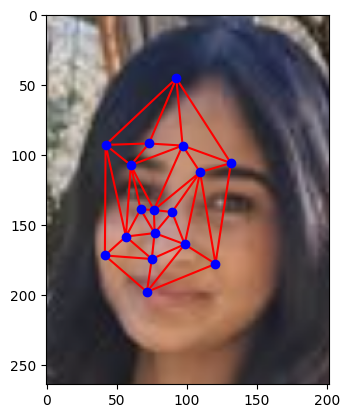

In [20]:
show_img_with_avg_triangulation(praneet, rizz_mean_points_tri)
show_img_with_avg_triangulation(shawty, rizz_mean_points_tri)

In [8]:
def compute_affine(destination, mean_info):
    source, indices = mean_info["img1_img2_mean_pts"], mean_info["mean_points_tri"].simplices
    matrices = [] # will store the affine transformation matrix for each triangle        
    
    # source = mean points
    # destination = img points
    # affine transformation describes mapping from mean -> source

    for triangle in indices:
        pt1, pt2, pt3 = source[triangle[0]], source[triangle[1]], source[triangle[2]]
        pt1_n, pt2_n, pt3_n = destination[triangle[0]], destination[triangle[1]], destination[triangle[2]]

        matrix_A = np.array([
            [pt1[0], pt1[1], 1, 0, 0, 0],
            [0, 0, 0, pt1[0], pt1[1], 1],
            [pt2[0], pt2[1], 1, 0, 0, 0],
            [0, 0, 0, pt2[0], pt2[1], 1],
            [pt3[0], pt3[1], 1, 0, 0, 0],
            [0, 0, 0, pt3[0], pt3[1], 1]
        ])

        q = np.array([pt1_n[0], pt1_n[1], pt2_n[0], pt2_n[1], pt3_n[0], pt3_n[1]])

        vars = np.linalg.solve(matrix_A, q)

        matrices.append(np.array([
            [vars[0], vars[1], vars[2]],
            [vars[3], vars[4], vars[5]],
            # [0, 0, 1]
        ]))

    return matrices

In [9]:
def warp_pixels(source, mean_info, img_pts):
    new_img, mean_pts, indices = np.zeros_like(source), mean_info["img1_img2_mean_pts"], mean_info["mean_points_tri"].simplices

    warp_matrices_source = compute_affine(mean_info[img_pts], mean_info) # affine transformations from mean points to img points

    for triangle, matrix in zip(indices, warp_matrices_source) : # [49, 43, 50]        
        y_coords, x_coords = [mean_pts[pt][1] for pt in triangle], [mean_pts[pt][0] for pt in triangle]
        r, c = polygon(y_coords, x_coords, source.shape)

        for y, x in zip(r, c):
            x_prime, y_prime = np.dot(matrix, np.array([x, y, 1]))
            x_prime, y_prime = int(x_prime), int(y_prime)

            new_img[y, x] = source[y_prime, x_prime]
                
    return new_img

In [9]:
warped_kobe, warped_jayz = warp_pixels(kobe, kobe_jayz_mean_points_tri, "img2_pts"), warp_pixels(jay_z, kobe_jayz_mean_points_tri, "img1_pts")

In [10]:
warped_praneet, warped_shawty = warp_pixels(praneet, rizz_mean_points_tri, "img1_pts"), warp_pixels(shawty, rizz_mean_points_tri, "img2_pts")

In [11]:
def show_warped_img_with_avg_triangulation(warped_img, mean_info, show_triangles=False):
    mean_points_tri, mean_points = mean_info["mean_points_tri"], mean_info["img1_img2_mean_pts"]
    
    fig, ax = plt.subplots()

    ax.imshow(warped_img)

    if show_triangles:
        ax.triplot(mean_points[:, 0], mean_points[:, 1], mean_points_tri.simplices, color='r')
        ax.plot(mean_points[:, 0], mean_points[:, 1], 'bo')
    
    plt.axis('off')
    plt.show()

# show_warped_img_with_avg_triangulation(warped_kobe, kobe_jayz_mean_points_tri, False)
# show_warped_img_with_avg_triangulation(warped_jayz, kobe_jayz_mean_points_tri, False)


In [12]:
def show_midway_face(img_1, img_2, correspondenceFile, show=True):
    mean_points_tri = get_mean_points_info(correspondenceFile)

    warped_img_1, warped_img_2 = warp_pixels(img_1, mean_points_tri, "img1_pts"), warp_pixels(img_2, mean_points_tri, "img2_pts")

    fig, ax = plt.subplots()

    warped_img1_img2_midway = (warped_img_1.astype(np.float32) + warped_img_2.astype(np.float32)) / 2
    warped_img1_img2_midway = warped_img1_img2_midway

    if show:
        ax.imshow(warped_img1_img2_midway.astype(np.uint8))
        plt.axis('off')
        plt.show()

    return [warped_img_1, warped_img_2]

#### Show midway face of Jay-Z and Kobe

ValueError: operands could not be broadcast together with shapes (234,162,3) (264,202,3) 

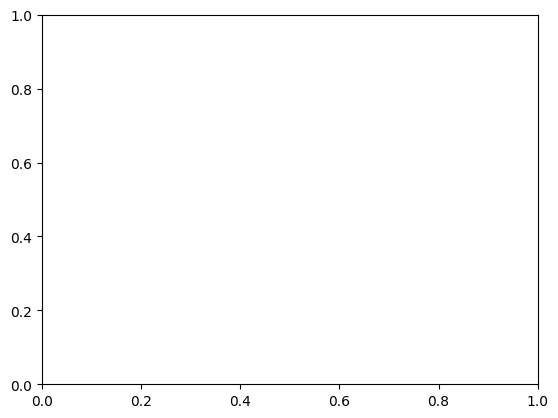

In [13]:
show_midway_face(praneet, shawty, '../media/praneet_shawty.json')

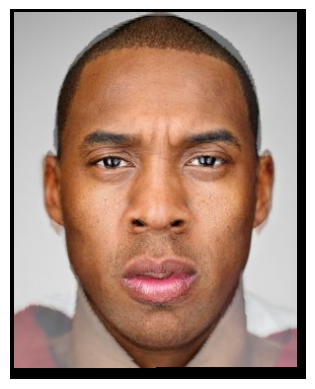

In [12]:
jay_z_warped, kobe_warped = show_midway_face(jay_z, kobe, '../media/jay_z_kobe.json')

#### Show midway face of George Clooney and Bradley Cooper

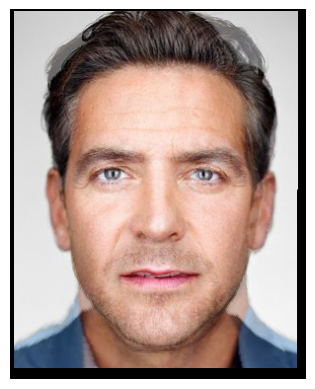

In [13]:
clooney, cooper = cv2.imread("../media/clooney.jpg"), cv2.imread("../media/cooper.jpg")
clooney, cooper = cv2.cvtColor(clooney, cv2.COLOR_BGR2RGB), cv2.cvtColor(cooper, cv2.COLOR_BGR2RGB)

clooney_warped, cooper_warped = show_midway_face(clooney, cooper, '../media/clooney_cooper.json')

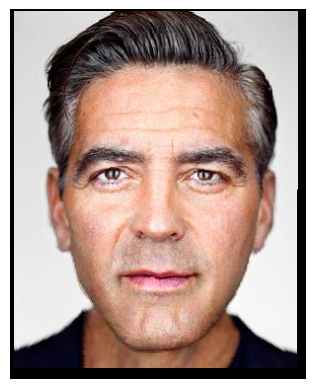

In [213]:
plt.axis('off')
plt.imshow(clooney_warped)

## Part 3: The Morph Sequence

In [14]:
def morph(im1, im2, correspondenceFile, warp_frac, dissolve_frac):
    points = json.load(open(correspondenceFile,))
    im1_pts, im2_pts = np.array(points["im1Points"]), np.array(points["im2Points"])
    
    custom_avg_pts = im1_pts * (1 - warp_frac) + im2_pts * (warp_frac)

    info = {
        "img1_pts": im1_pts,
        "img2_pts": im2_pts,
        "img1_img2_mean_pts": custom_avg_pts,
        "mean_points_tri": Delaunay(custom_avg_pts)
    }

    im1_warped, im2_warped = warp_pixels(im1, info, "img1_pts"), warp_pixels(im2, info, "img2_pts")

    final_image = im1_warped * (1 - dissolve_frac) + im2_warped * (dissolve_frac)
    # final_image = final_image.astype(np.uint8)
    
    return final_image

def gif(im1, im2, correspondenceFile, frames=45, fps=30):
    frame_lst = []

    for i in range(frames + 1):
        warp_frac, dissolve_frac = i / frames, i / frames

        morphed_img = morph(im1, im2, correspondenceFile, warp_frac, dissolve_frac)

        frame_lst.append(morphed_img)

    imageio.mimsave("../media/morphed_gif.gif", frame_lst, fps=fps)

In [15]:
gif(clooney, cooper, '../media/clooney_cooper.json', frames=240)

## Part 4: The "Mean face" of a population

In [15]:
white_men_subset = {
    "16-1m": [],
    "25-1m": [],
    "33-1m": [],
    "36-1m": []
}
white_men = []

for file in white_men_subset.keys():
    picture_path, correspondence_points_path = f'../media/mean_pop/{file}.jpg', f'../media/mean_pop/{file}.asf'
    
    white_man = cv2.imread(picture_path)
    white_man = cv2.cvtColor(white_man, cv2.COLOR_BGR2RGB)

    white_men.append(white_man)

    y_scaling, x_scaling = white_man.shape[0], white_man.shape[1]

    with open(correspondence_points_path, 'r') as file_name:
        for line in file_name:
            line = line.split()
            
            x, y = float(line[2]) * x_scaling, float(line[3]) * y_scaling
            
            white_men_subset[file].append([x, y])
        
    white_men_subset[file].extend([[0, 0], [0, y_scaling - 1], [x_scaling - 1, 0], [x_scaling - 1, y_scaling - 1]]) # [0, 0] [0, 639] [479, 0] [479, 639]

for key in white_men_subset.keys():
    white_men_subset[key] = np.array(white_men_subset[key])

In [16]:
average_dane_mean_pts = (white_men_subset["16-1m"] + white_men_subset["25-1m"] + white_men_subset["33-1m"] + white_men_subset["36-1m"]) / len(white_men_subset.keys())
average_dane_tri = Delaunay(average_dane_mean_pts)

danes_info = {
    "img1_img2_mean_pts": average_dane_mean_pts,
    "mean_points_tri": average_dane_tri,
    "img1_pts": white_men_subset["16-1m"],
    "img2_pts": white_men_subset["25-1m"],
    "img3_pts": white_men_subset["33-1m"],
    "img4_pts": white_men_subset["36-1m"],
}

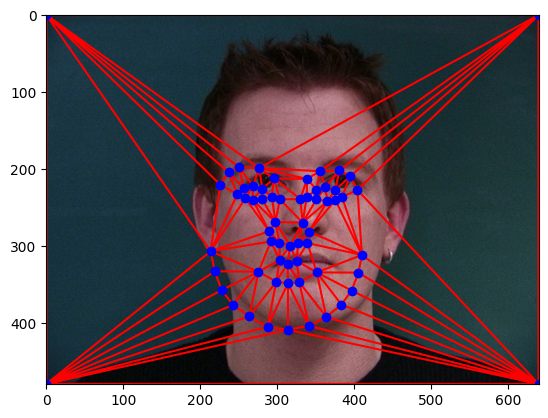

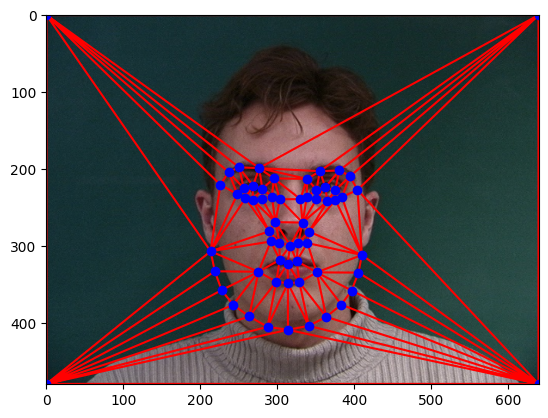

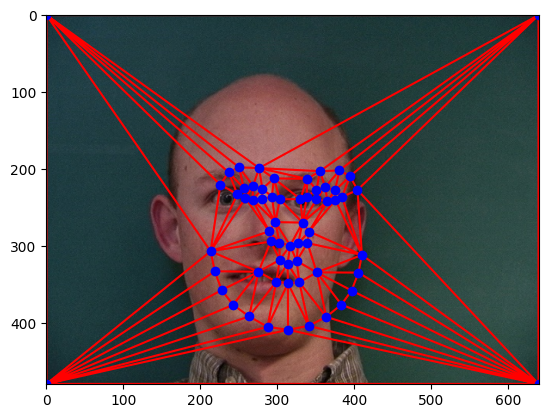

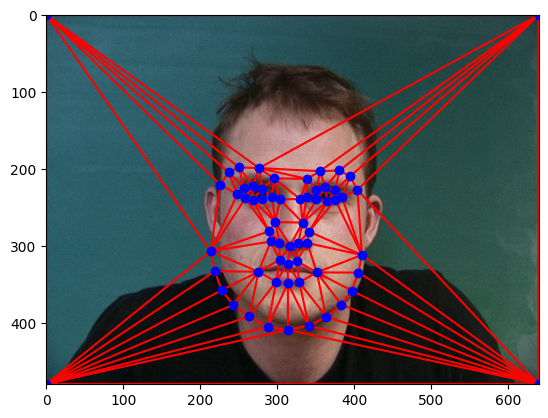

In [15]:
for man in white_men:
    show_img_with_avg_triangulation(man, danes_info)

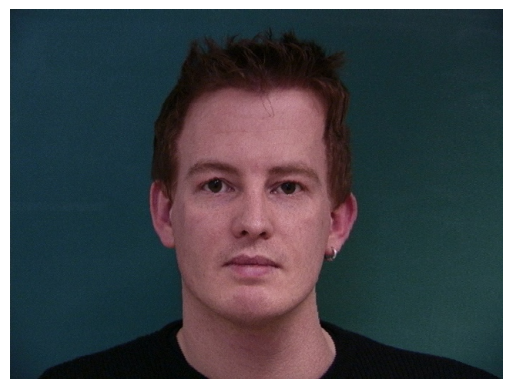

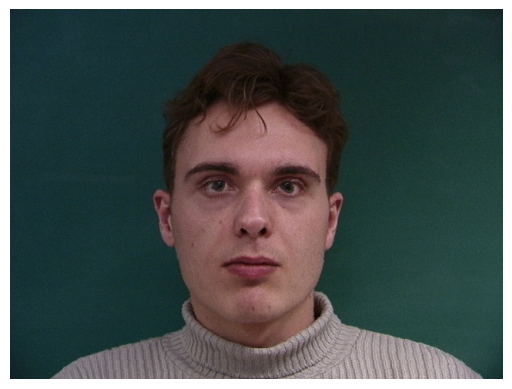

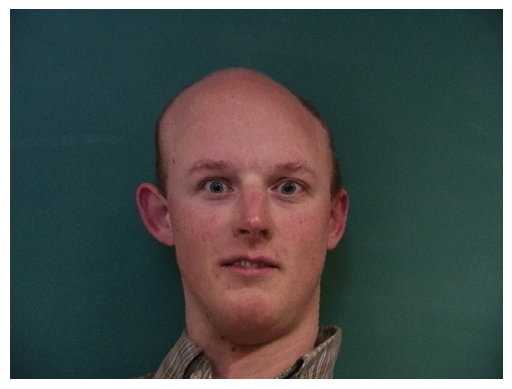

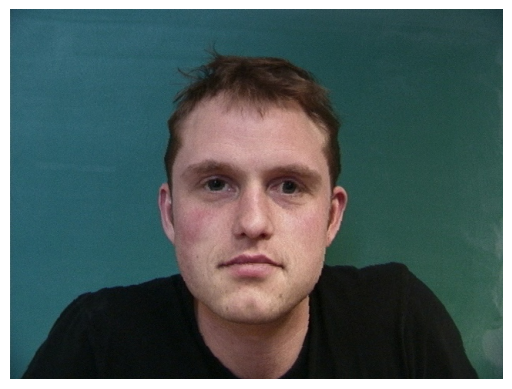

In [17]:
warped_imgs = []

for i, imgs in enumerate(white_men_subset.values()):
    warped = warp_pixels(white_men[i], danes_info, f"img{i + 1}_pts")

    warped_imgs.append(warped)

    fig, ax = plt.subplots()

    ax.imshow(warped)

    plt.axis('off')
    plt.show()

In [18]:
def midway_face_many_imgs(warped_imgs_lst):
    total = 0

    for warped in warped_imgs_lst:
        warped = warped.astype(np.float32)

        total += warped

    total = total / len(warped_imgs_lst)

    total = total.astype(np.uint8)

    fig, ax = plt.subplots()

    ax.imshow(total)

    plt.axis('off')
    plt.show()

    return total

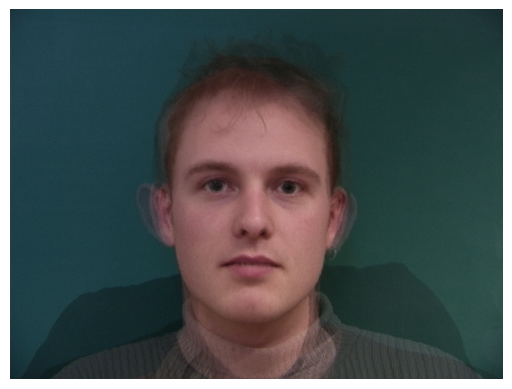

In [19]:
white_male_pop_average = midway_face_many_imgs(warped_imgs)

In [20]:
saatvik = cv2.imread('../media/mean_pop/saatvik.jpeg')
saatvik = cv2.cvtColor(saatvik, cv2.COLOR_BGR2RGB)

saatvik = sk.transform.resize(saatvik, (480, 640, 3))

In [21]:
saatvik_avg_whites_tri = get_mean_points_info('../media/mean_pop/saatvik_resized_white_males_averaged.json')

#### Saatvik warped to Average

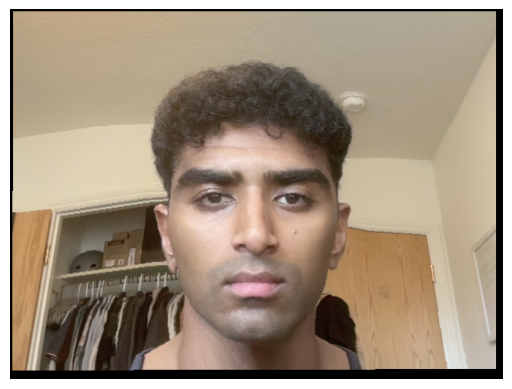

In [22]:
warped_saatvik = warp_pixels(saatvik, saatvik_avg_whites_tri, 'img1_pts')

plt.axis('off')
plt.imshow(warped_saatvik)

#### Average warped to Saatvik

In [23]:
def compute_affine_custom(destination, mean_pts, tri):
    source, indices = mean_pts, tri.simplices
    matrices = [] # will store the affine transformation matrix for each triangle        
    
    # source = mean points
    # destination = img points
    # affine transformation describes mapping from mean -> source

    for triangle in indices:
        pt1, pt2, pt3 = source[triangle[0]], source[triangle[1]], source[triangle[2]]
        pt1_n, pt2_n, pt3_n = destination[triangle[0]], destination[triangle[1]], destination[triangle[2]]

        matrix_A = np.array([
            [pt1[0], pt1[1], 1, 0, 0, 0],
            [0, 0, 0, pt1[0], pt1[1], 1],
            [pt2[0], pt2[1], 1, 0, 0, 0],
            [0, 0, 0, pt2[0], pt2[1], 1],
            [pt3[0], pt3[1], 1, 0, 0, 0],
            [0, 0, 0, pt3[0], pt3[1], 1]
        ])

        q = np.array([pt1_n[0], pt1_n[1], pt2_n[0], pt2_n[1], pt3_n[0], pt3_n[1]])

        vars = np.linalg.solve(matrix_A, q)

        matrices.append(np.array([
            [vars[0], vars[1], vars[2]],
            [vars[3], vars[4], vars[5]],
            # [0, 0, 1]
        ]))

    return matrices


def warp_pixels_custom(source, source_pts, mean_pts, tri):

    new_img, mean_pts, indices = np.zeros_like(source), mean_pts, tri.simplices

    warp_matrices_source = compute_affine_custom(source_pts, mean_pts, tri) # affine transformations from mean points to img points

    for triangle, matrix in zip(indices, warp_matrices_source) : # [49, 43, 50]        
        y_coords, x_coords = [mean_pts[pt][1] for pt in triangle], [mean_pts[pt][0] for pt in triangle]
        r, c = polygon(y_coords, x_coords, source.shape)

        for y, x in zip(r, c):
            x_prime, y_prime = np.dot(matrix, np.array([x, y, 1]))
            x_prime, y_prime = int(x_prime), int(y_prime)

            new_img[y, x] = source[y_prime, x_prime]
            
    return new_img

In [24]:
warped_average_white_man = warp_pixels_custom(white_male_pop_average, saatvik_avg_whites_tri["img2_pts"], saatvik_avg_whites_tri["img1_pts"], saatvik_avg_whites_tri["mean_points_tri"])

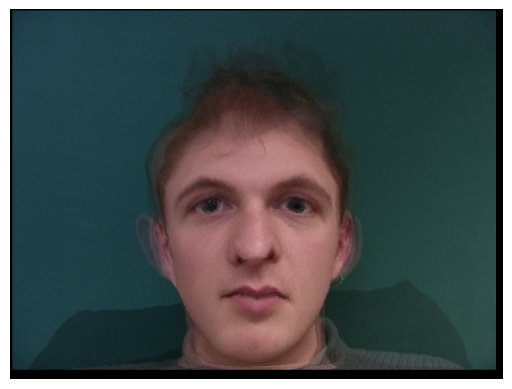

In [25]:
plt.axis('off')
plt.imshow(warped_average_white_man)

## Part 5: Caricatures: Extrapolating from the mean

In [26]:
def caricature(im1, im2, correspondenceFile, warp_frac, dissolve_frac):
    points = json.load(open(correspondenceFile,))
    im1_pts, im2_pts = np.array(points["im1Points"]), np.array(points["im2Points"])

    caricature_pts = im1_pts + (warp_frac) * (im2_pts - im1_pts)

    info = {
        "img1_pts": im1_pts,
        "img2_pts": im2_pts,
        "img1_img2_mean_pts": caricature_pts,
        "mean_points_tri": Delaunay(caricature_pts)
    }

    im1_warped = warp_pixels(im1, info, "img1_pts")

    return im1_warped

In [27]:
c_1_more = caricature(saatvik, white_male_pop_average, '../media/mean_pop/saatvik_resized_white_males_averaged.json', 1.5, 0)
c_1_less = caricature(saatvik, white_male_pop_average, '../media/mean_pop/saatvik_resized_white_males_averaged.json', -1.5, 0)

In [28]:
simoni = cv2.imread('../media/mean_pop/simoni.jpg')
simoni = cv2.cvtColor(simoni, cv2.COLOR_BGR2RGB)

In [29]:
simoni = sk.transform.resize(simoni, (480, 640, 3))


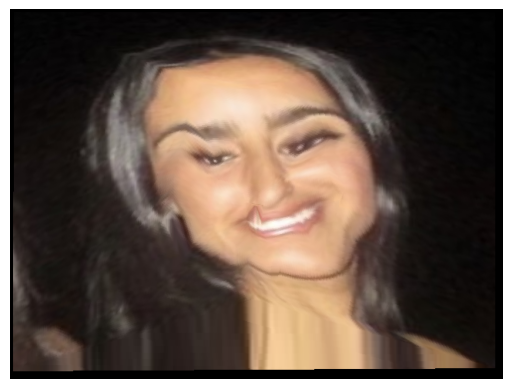

In [33]:
c_1_more_simoni = caricature(simoni, white_male_pop_average, '../media/mean_pop/saatvik_resized_white_males_averaged.json', 1.5, 0)

plt.axis('off')
plt.imshow(c_1_more_simoni)

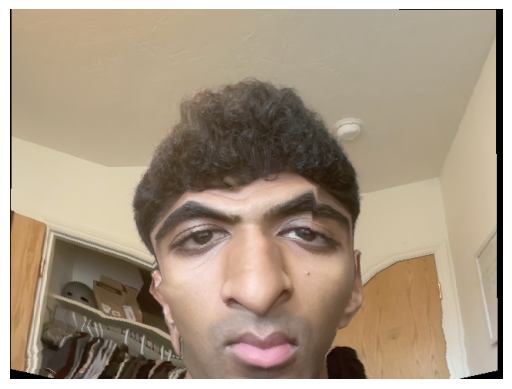

In [200]:
plt.axis('off')
plt.imshow(c_1_less)

## Bells and Whistles

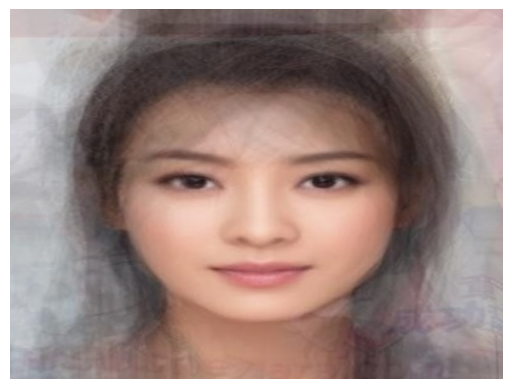

In [30]:
avg_chinese_woman = cv2.imread('../media/mean_pop/average_chinese_woman.jpg')
avg_chinese_woman = cv2.cvtColor(avg_chinese_woman, cv2.COLOR_BGR2RGB)
avg_chinese_woman = sk.transform.resize(avg_chinese_woman, (480, 640, 3))

plt.axis('off')
plt.imshow(avg_chinese_woman)

In [32]:
chinese_woman_saatvik_tri = get_mean_points_info('../media/mean_pop/saatvik_resized_average_chinese_woman.json')
warped_saatvik_chinese_shape = warp_pixels(saatvik, chinese_woman_saatvik_tri, "img1_pts")

In [33]:
warped_simoni_chinese_shape = warp_pixels(simoni, chinese_woman_saatvik_tri, "img1_pts")

In [205]:
warped_saatvik_chinese_colors = morph(saatvik, avg_chinese_woman, '../media/mean_pop/saatvik_resized_average_chinese_woman.json', 0, 1)

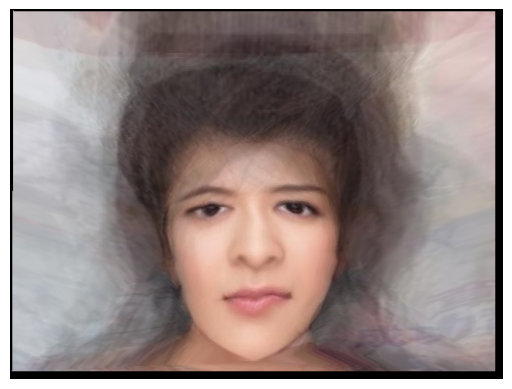

In [196]:
plt.axis('off')
plt.imshow(warped_saatvik_chinese_colors)

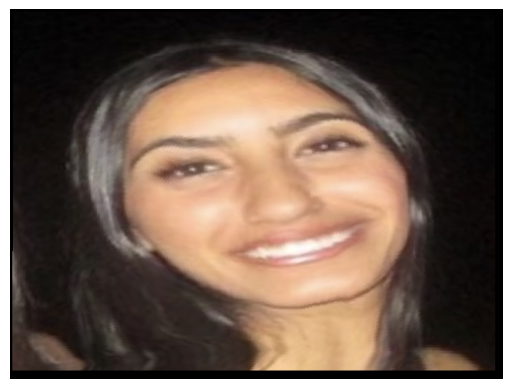

In [34]:
plt.axis('off')
plt.imshow(warped_simoni_chinese_shape)

In [206]:
warped_saatvik_chinese_both = morph(saatvik, avg_chinese_woman, '../media/mean_pop/saatvik_resized_average_chinese_woman.json', 0.5, 0.5)

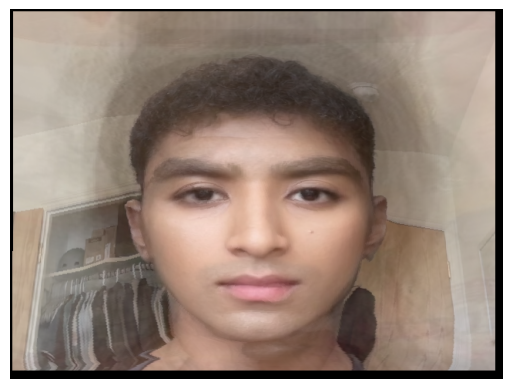

In [207]:
plt.axis('off')
plt.imshow(warped_saatvik_chinese_both)